# 📊 Análisis espectral de la aceleración
Esta plantilla te ayudará a:
- Cargar una señal de aceleración vs tiempo
- Aplicar la Transformada Discreta de Fourier (DFT)
- Identificar los armónicos dominantes
- Reconstruir la señal con los primeros armónicos

👉 Asegúrate de tener tus datos en un archivo `.txt` o `.csv` con columnas de tiempo y aceleración.

In [32]:
# ✅ Librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Configuración de gráficos
plt.rcParams['figure.figsize'] = (12, 5)


## 📁 1. Cargar archivo de datos
Modifica esta celda para que apunte a tu archivo de datos con columnas de tiempo y aceleración.

In [ ]:
# Cargar datos desde archivo
# Reemplaza 'archivo.txt' con el nombre de tu archivo
df = pd.read_csv("data/30hz.txt", sep="\t", skiprows=5)
df.columns = ['Tiempo','Posición','Velocidad1','Aceleración1','Ángulo', 'Velocidad2', 'Aceleración2']
# Visualizar las primeras filas
df.head()

,Tiempo,Posición,Velocidad1,Aceleración1,Ángulo,Velocidad2,Aceleración2
0,0.033333,0.564235,0.048020,-0.611529,0.0,0.000000,0.000000
1,0.066666,0.566465,0.026368,-0.531470,0.0,0.000000,0.018181
2,0.099999,0.566465,0.006346,-0.368196,0.0,0.000000,0.094541
3,0.133332,0.566293,0.001000,-0.185688,0.0,0.000000,0.412100
4,0.166665,0.566465,-0.001715,-0.111084,0.0,0.014545,1.078732


## 🔍 2. Seleccionar intervalo aproximadamente periódico
Selecciona una parte de la señal donde se vea un comportamiento cíclico.

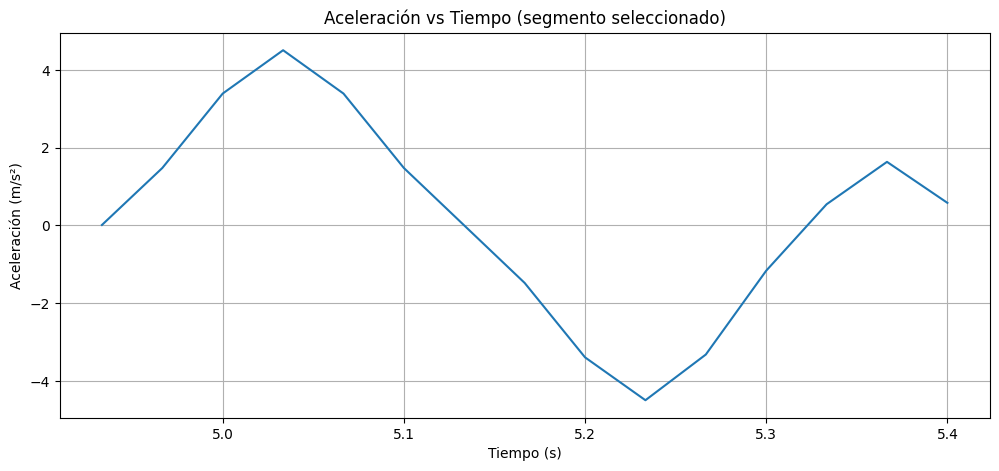

In [34]:
# Acotar datos a un intervalo periódico
inicio, fin = 4.9, 5.4  # segundos
mask = (df['Tiempo'] >= inicio) & (df['Tiempo'] <= fin)
t = df.loc[mask, 'Tiempo'].values
a = df.loc[mask, 'Aceleración2'].values

# Mostrar la señal
plt.plot(t, a)
plt.title("Aceleración vs Tiempo (segmento seleccionado)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Aceleración (m/s²)")
#plt.xticks(np.arange(t[0], t[-1], 1))  # marcas cada 0.1 segundos
plt.grid()
plt.show()

## ⚙️ 3. Calcular la DFT y obtener el espectro de amplitudes

0.03333300000000072


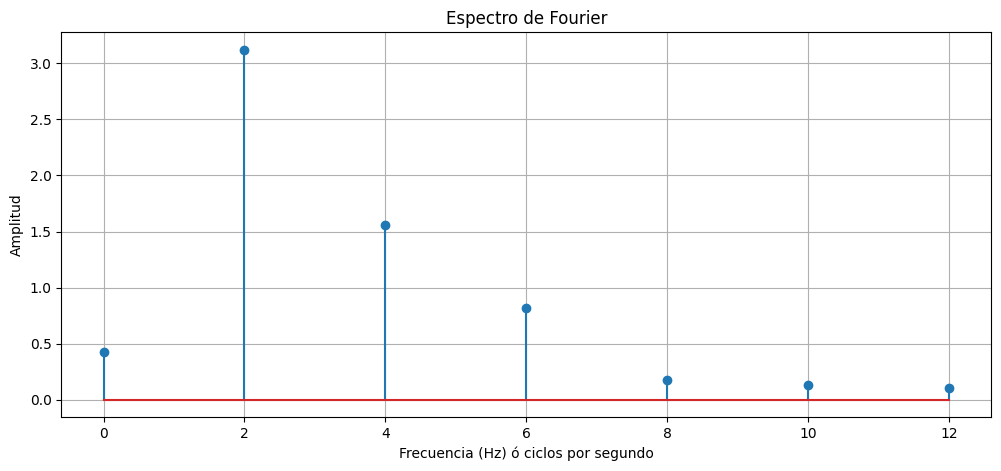

In [35]:
# Parámetros de muestreo
N = len(t)
T = t[1] - t[0]
print(T)
f_s = 1 / T # Frecuencia de muestreo 

# FFT
yf = fft(a)
xf = fftfreq(N, T)[:N // 2]
amplitudes = 2.0 / N * np.abs(yf[:N // 2])

# Espectro
plt.stem(xf, amplitudes)
plt.title("Espectro de Fourier")
plt.xlabel("Frecuencia (Hz) ó ciclos por segundo")
plt.ylabel("Amplitud")
#plt.xlim(0, 25)
plt.grid()
plt.show()

## 📌 4. Identificar los dos primeros armónicos dominantes

In [36]:
# FFT previa: asume que ya tienes xf y amplitudes
threshold = np.max(amplitudes) * 0.1
rango_frecuencias = (xf >= 0) & (xf <= 5)
condicion = (amplitudes > threshold) & rango_frecuencias

filtered_freqs = xf[condicion]
filtered_amps = amplitudes[condicion]

# Crear tabla ordenada por frecuencia (no por amplitud)
dominant_df_filtered = pd.DataFrame({
    "Frecuencia (Hz)": filtered_freqs,
    "Amplitud": filtered_amps
}).sort_values(by="Frecuencia (Hz)").reset_index(drop=True)

# Mostrar la tabla
print(dominant_df_filtered.head())

   Frecuencia (Hz)  Amplitud
0          0.00000  0.423412
1          2.00002  3.121510
2          4.00004  1.554555


In [37]:
dominant_df_filtered

,Frecuencia (Hz),Amplitud
0,0.00000,0.423412
1,2.00002,3.121510
2,4.00004,1.554555


## 🧱 5. Reconstrucción de la señal con los dos primeros armónicos

-0.0
-0.8233612851234785


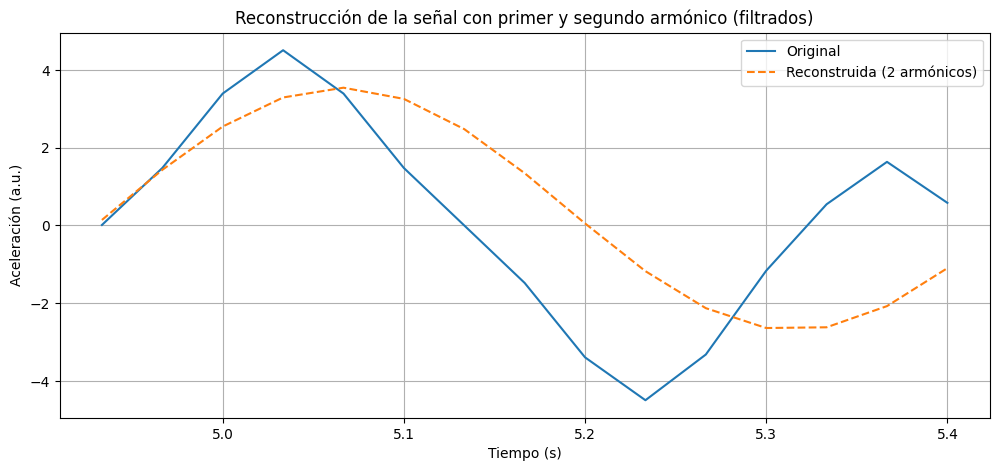

,Frecuencia (Hz),Amplitud
0,0.00000,0.423412
1,2.00002,3.121510
2,4.00004,1.554555


In [38]:
# Reconstrucción con las dos primeras frecuencias físicas ordenadas
phases = np.angle(yf)
reconstructed = np.zeros_like(t)

for f in dominant_df_filtered["Frecuencia (Hz)"].head(2):  # solo las dos primeras por frecuencia
    idx = np.argmin(np.abs(xf - f))
    A = amplitudes[idx]
    phi = phases[idx]
    print(phi)
    reconstructed += A * np.cos(2 * np.pi * f * t + phi)

# Comparación visual
plt.plot(t, a, label="Original")
plt.plot(t, reconstructed, label="Reconstruida (2 armónicos)", linestyle="--")
plt.title("Reconstrucción de la señal con primer y segundo armónico (filtrados)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Aceleración (a.u.)")
plt.legend()
plt.grid()
plt.show()
display(dominant_df_filtered)

## ✏️ 6. Conclusión
Comenta lo siguiente:
- ¿Qué tan bien se aproxima la reconstrucción a la señal original?
- ¿Qué información se pierde?
- ¿Los armónicos encontrados tienen sentido físico?
- ¿Hay otros picos en el espectro? ¿Podrían deberse a ruido o efectos mecánicos del sistema?